# Density correlation function

## Method 
The density correlation function (DCF) is by definition given as:
$$
\xi(\mathbf{r},t) = \frac{1}{\bar{n}^2} \langle \left(n(\mathbf{x},t)-\bar{n}\right) \left(n(\mathbf{x}+
\mathbf{r},t)-\bar{n}\right)\rangle
$$

Expanding the average into a volume average:
\begin{align*}
&\langle \left(n(\mathbf{x},t)-\bar{n}\right) \left(n(\mathbf{x}+
\mathbf{r},t)-\bar{n}\right)\rangle\\
=& \frac{\int_\mathcal{V} \left(n(\mathbf{x},t)-\bar{n}\right) \left(n(\mathbf{x}+
\mathbf{r},t)-\bar{n}\right) d^3 \mathbf{x}}{ \int_\mathcal{V}d^3 \mathbf{x}}\\
=& \frac{1}{N_1 N_2 N_3} \sum_{i,j,k} \left(n_{i,j,k}^{(t)}-\bar{n}\right) \left(n_{(i+i'),(j+j'),(k+k')}^{(t)}-\bar{n}\right)
\end{align*}

This lower one will be the equation I am using to calculate the DCF (At least naively, just to make sure things are as simple as possible and make sure I don't mess up silly things again)

For simplicity, I will allow $i',j',k'$ to get from range 0-256 and let it wrap around the corner. The resulting block will then be centered using fft shift function to obtain the DCF in block form

So finally the thing we need to compute is really:

\begin{align*}
\xi(\mathbf{r},t) = \frac{1}{N_1 N_2 N_3} \sum_{i,j,k} \left(\tilde{n}_{i,j,k}^{(t)}-1\right) \left(\tilde{n}_{(i+i'),(j+j'),(k+k')}^{(t)}-1\right)
\end{align*}

where where $\tilde{n}_{i,j,k}^{(t)} = n^{(t)}_{i,j,k}\,/\,\bar{n}$

Since the clustering is isotropic, we expect $\xi$ to depend only on $r$. This motivate us to define the radial average of $\xi$, given as:

\begin{align*}
\xi(r,t) &= \frac{1}{4\pi} \int_\Omega \xi(\mathbf{r},t) d\Omega\\
&= \lim_{\Delta r \to 0}\frac{\int_{[R,R+\Delta r]}  \xi(\mathbf{r},t)\,d^3\mathbf{r}}{\int_{[R,R+\Delta r]}  \,d^3\mathbf{r}}
\end{align*}

However, since we are using histogram, we are always averaging over an interval $\Delta r$. This means if the bin width is too large, then we might average over too many grid points. In the case like RDF of dust, where the number density drops rapidly with distance, this will lead to a drop in peak RDF value when the the bin width are too large. Reducing bin width will lead to a more accurate result


Finally, the radial distribution function can be obtained by simply adding 1 to the correlation (Shaw 2003; Pan et. al. 2001)

\begin{align*}
g(r,t) = 1 + \xi(r,t)
\end{align*}

In [166]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

In [167]:
data_out = sorted(list(glob.glob('./data-out/*')))
data_tgt = sorted(list(glob.glob('./data-tgt/*')))
len(data_out),len(data_tgt)

(7, 7)

In [168]:
def read_npy(paths,sep=2):
    npys = []
    for i,path in enumerate(paths):
        npys.append(np.load(path))
        if i % sep == 0:
            print(f'{i}:Loading {path} {npys[-1].shape}')
    print(f'Total of {len(npys)} files loaded')
    return npys

In [169]:
npys_out = read_npy(data_out)
npys_tgt = read_npy(data_tgt)

0:Loading ./data-out/TurbPar.out2.00110-preped-rhop_out.npy (1, 256, 256, 256)
2:Loading ./data-out/TurbPar.out2.00120-preped-rhop_out.npy (1, 256, 256, 256)
4:Loading ./data-out/TurbPar.out2.00131-preped-rhop_out.npy (1, 256, 256, 256)
6:Loading ./data-out/TurbPar.out2.00138-preped-rhop_out.npy (1, 256, 256, 256)
Total of 7 files loaded
0:Loading ./data-tgt/TurbPar.out2.00110-preped-rhop.npy (1, 256, 256, 256)
2:Loading ./data-tgt/TurbPar.out2.00120-preped-rhop.npy (1, 256, 256, 256)
4:Loading ./data-tgt/TurbPar.out2.00131-preped-rhop.npy (1, 256, 256, 256)
6:Loading ./data-tgt/TurbPar.out2.00138-preped-rhop.npy (1, 256, 256, 256)
Total of 7 files loaded


In [170]:
def downsample(arr,kernel):
    tsr = torch.from_numpy(arr)
    pool = nn.AvgPool3d(kernel_size=kernel)
    return pool(tsr).numpy()

In [216]:
def plot_compare(out,tgt):
    eps = np.unique(out)[1]
    print('Epsilon:', eps)
    out_slice = out[0,:,:,out.shape[-1]//2]
    tgt_slice = tgt[0,:,:,tgt.shape[-1]//2]
    print(out_slice.shape, tgt_slice.shape)
    
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
    
    axs[0].set_title(f'Out slice; Dimension: {out.shape}')
    axs[1].set_title(f'Tgt slice; Dimension: {tgt.shape}')
    axs[0].pcolormesh(np.log(out_slice+eps))
    axs[1].pcolormesh(np.log(tgt_slice+eps))

Epsilon: 6.1812216e-10
(85, 85) (85, 85)


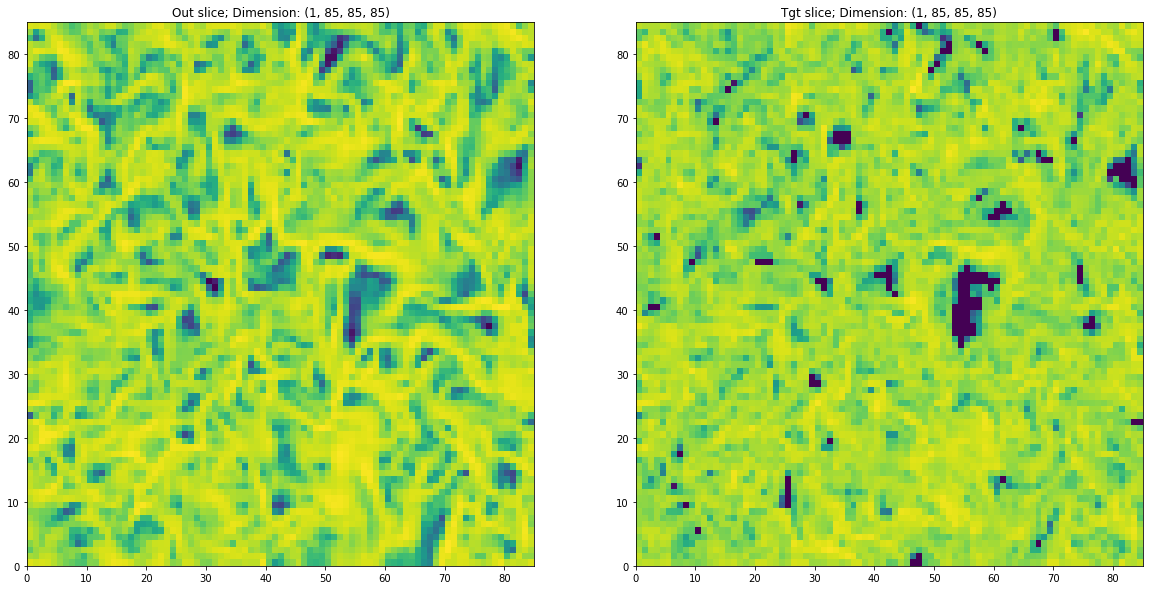

In [217]:
plot_compare(downsample(npys_out[0],(3,3,3)),downsample(npys_tgt[0],(3,3,3))) # Downsample to allow the slow dcf to run faster

In [173]:
def prod(items):
    return functools.reduce(lambda x, y: x * y, base_shape)

def reduce_offsets(offsets, shape, direct=True):
    offsets = tuple(
        (offset if direct else (dim - offset)) % dim
        for offset, dim in zip(offsets, shape))
    return offsets

def cyclic_padding_tile_roll(arr, shape, offsets):
    offsets = reduce_offsets(offsets, arr.shape, False)
    tiling = tuple(
        new_dim // dim + (1 if new_dim % dim else 0)
        for offset, dim, new_dim in zip(offsets, arr.shape, shape))
    slicing = tuple(slice(0, new_dim) for new_dim in shape)
    if any(offset != 0 for offset in offsets):
        nonzero_offsets_axes, nonzero_offsets = tuple(zip(
            *((axis, offset) for axis, offset in enumerate(offsets)
            if offset != 0)))
        arr = np.roll(arr, nonzero_offsets, nonzero_offsets_axes)
    result = np.tile(arr, tiling)[slicing]
    return result

In [174]:
def dcf_naive(n): # Using a very bad implementation to test things out first (This is SUPER SLOW!)
    N1,N2,N3=n.shape
    n_bar = np.mean(n)
    n_tdm1 = n/n_bar -1 # n tilde - 1
    xi = np.zeros_like(n)
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                #if i % (N1//2) == 0 or j % (N2//2) or k % (N3//2):
                #print(i,j,k)
                n_tdm1_shift = cyclic_padding_tile_roll(n_tdm1,[N1,N2,N3],[i,j,k]) # Using some numpy magic on stack exchange (https://stackoverflow.com/questions/56005146/numpy-n-dim-array-with-periodic-boundary-conditions)
                xi[i,j,k] = np.sum(n_tdm1*n_tdm1_shift)
                #print(np.max(n_tdm1_shift-n_tdm1))
        print(i,j,k)
    xi /= (N1*N2*N3)
    return xi

In [175]:
#dcf_naive(downsample(npys_out[0],(3,3,3)).squeeze())

In [193]:
# Because the naive one is really to slow, so I just run once with a down sampled field and cache the result :p
dcf_slow = np.load('./dcf_slow.npy')# dcf_naive(downsample(npys_out[0],(3,3,3)).squeeze()) # 
np.max(dcf_slow)

1.2902151

In [194]:
np.save('dcf_slow.npy',dcf_slow)

In [195]:
shifted = np.fft.fftshift(dcf_slow)
shifted.shape

(85, 85, 85)

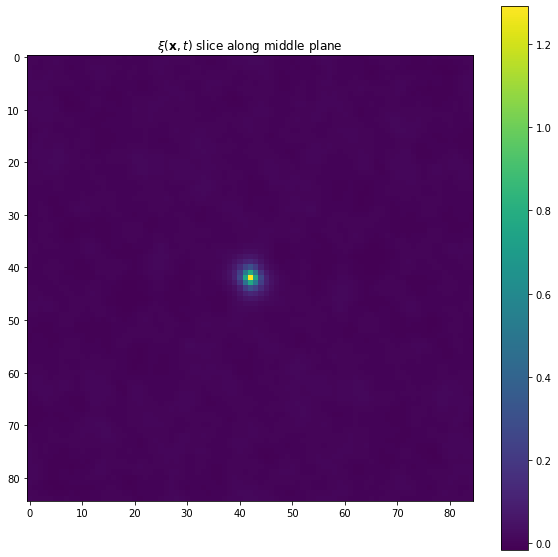

In [196]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
im = ax.imshow(shifted[85//2,:,:])
plt.title(r'$\xi(\mathbf{x},t)$ slice along middle plane')
plt.colorbar(im, ax=ax)

Text(0.5, 1.0, '$\\xi(\\mathbf{x},t)$ slice along middle line')

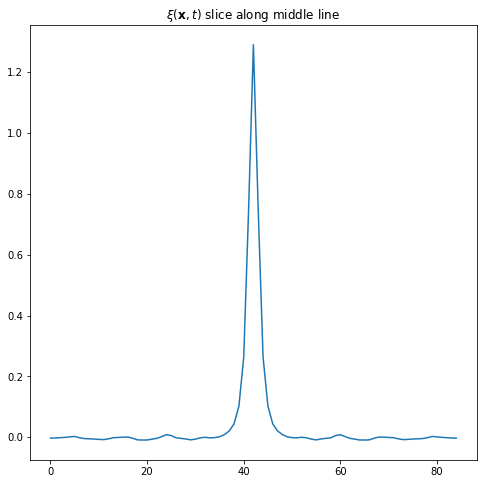

In [197]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
dcf = shifted[85//2,85//2,:]
ax.plot(dcf)
ax.set_title(r'$\xi(\mathbf{x},t)$ slice along middle line')

In [198]:
def R2_like(field):
    axes = [np.fft.fftfreq(dim,d=1/dim) for dim in field.shape]
    if len(axes) == 3:
        axes=axes[0][:,None,None],axes[1][None,:,None],axes[2][None,None,:]
    else:
        axes=axes[0][:,None],axes[1][None,:]
    return np.sum(np.array([ax**2 for ax in axes],dtype=object)) # Create radial axes

def radial_binning(field,bin_count=10): # Give radial average of field. Assume input field unshifted
    R = np.sqrt(R2_like(field))
    
    radial_bin, edges, _ = sp.stats.binned_statistic(R.flatten(),field.flatten(),statistic='mean',bins=bin_count)
    rs = 0.5*(edges[1:]+edges[:-1])
    return rs,radial_bin
    
    

In [199]:
rs,rbin = radial_binning(dcf_slow,bin_count=80)

Text(0, 0.5, '$\\xi(r,t)$')

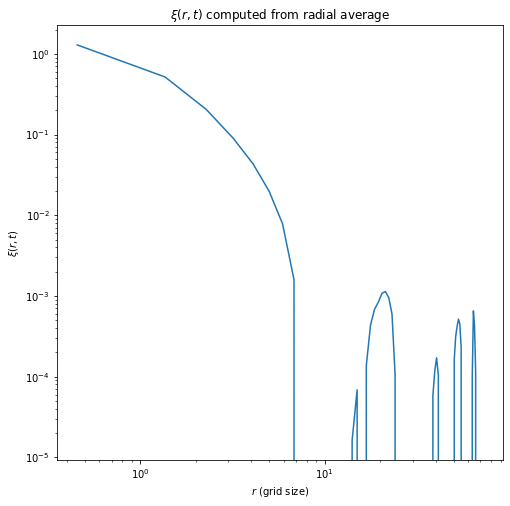

In [183]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs,rbin)
ax.set_title(r'$\xi(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$\xi(r,t)$')

Text(0, 0.5, '$g(r,t)$ (Radial distribution function)')

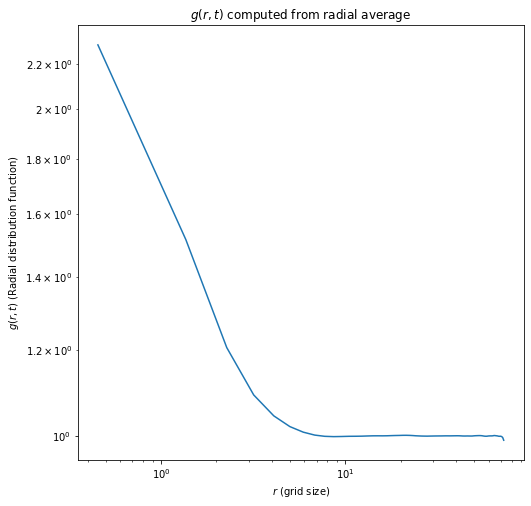

In [184]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs,1+rbin)
ax.set_title(r'$g(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$g(r,t)$ (Radial distribution function)')

## Optimize code using FFT

While the naive method is easy to implement. It's very inefficient. Therefore, a FFT based approach is introduced. Recall our target function is:
\begin{align*}
\xi(\mathbf{r},t) = \frac{1}{N_1 N_2 N_3} \sum_{i,j,k} \left(\tilde{n}_{i,j,k}^{(t)}-1\right) \left(\tilde{n}_{(i+i'),(j+j'),(k+k')}^{(t)}-1\right)
\end{align*}

Now, adopting the definition from wikipedia, the the discrete fourier transform (DFT) of an array is:

\begin{align*}
X_\mathbf{k} = \sum_{\mathbf{n}=0}^{\mathbf{N-1}} x_\mathbf{n} \exp\left(-i\frac{2\pi \mathbf{n}\cdot \mathbf{k}}{\mathbf{N}}\right)
\end{align*}

where $\mathbf{N}=(N_1,N_2,\cdots,N_m)$, $\mathbf{k}=(k_1,k_2,\cdots,k_m)$, and ${\mathbf{n}\cdot \mathbf{k}}/{\mathbf{N}}$ denote element wise division. 

Then if we define the periodic cross correlation between two array to be:
\begin{align*}
\left(x \star y\right)_\mathbf{r} = \sum_{\mathbf{n}=0}^{\mathbf{N-1}} (x_\mathbf{n})^* (y_{\mathbf{n+r}})
\end{align*}
where out of range values are assumed to wrap periodically around the array. Then it's easy to show the following convolution theorem:
\begin{align*}
\mathcal{F}\left[x \star y\right] = \left(\mathcal{F}\left[x\right]\right)^* \, \left(\mathcal{F}\left[y\right]\right)
\end{align*}

In fact, since our definition of DFT and IDFT here is just the same as numpy, so we only need to call all those DFT and IDFT without modification and divide by $N_1N_2N_3$ at the end to obtain the desired cross correlation.

In [185]:
def dcf_fft(n):
    N1,N2,N3 = n.shape
    n_bar = np.mean(n)
    n_tdm1 = n/n_bar -1 # n tilde - 1
    fft_n_tdm1 = np.fft.fftn(n_tdm1)
    #print(np.conj(fft_n_tdm1),fft_n_tdm1)
    dcf = np.fft.ifftn(np.conj(fft_n_tdm1)*fft_n_tdm1)
    return np.real(dcf)/(N1*N2*N3)
    #return np.real(dcf)/

In [186]:
dcf_fast = dcf_fft(downsample(npys_out[0],(3,3,3)).squeeze())

In [187]:
shifted = np.fft.fftshift(dcf_fast)
shifted.shape
N_mid = shifted.shape[0]//2
shifted.shape,N_mid

((85, 85, 85), 42)

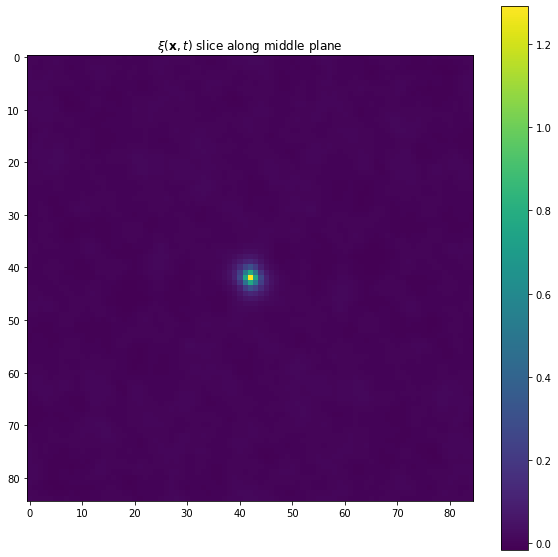

In [188]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
im = ax.imshow(shifted[N_mid,:,:])
plt.title(r'$\xi(\mathbf{x},t)$ slice along middle plane')
plt.colorbar(im, ax=ax)

Text(0.5, 1.0, '$\\xi(\\mathbf{x},t)$ slice along middle line')

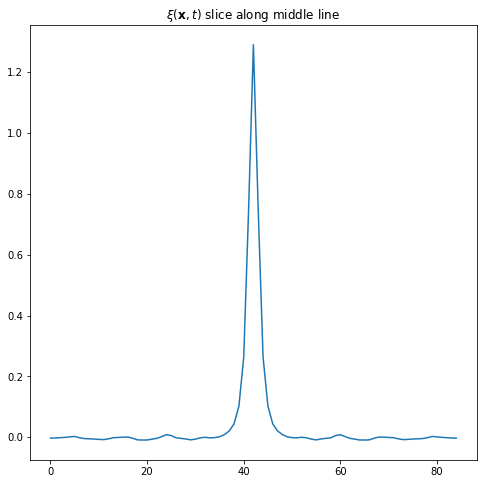

In [189]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
dcf = shifted[N_mid,N_mid,:]
ax.plot(dcf)
ax.set_title(r'$\xi(\mathbf{x},t)$ slice along middle line')

In [200]:
rs,rbin = radial_binning(dcf_fast,bin_count=80)

Text(0, 0.5, '$\\xi(r,t)$')

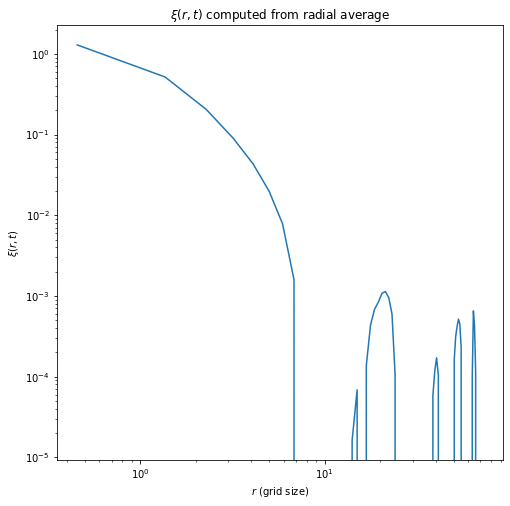

In [201]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs,rbin)
ax.set_title(r'$\xi(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$\xi(r,t)$')

Text(0, 0.5, '$g(r,t)$ (Radial distribution function)')

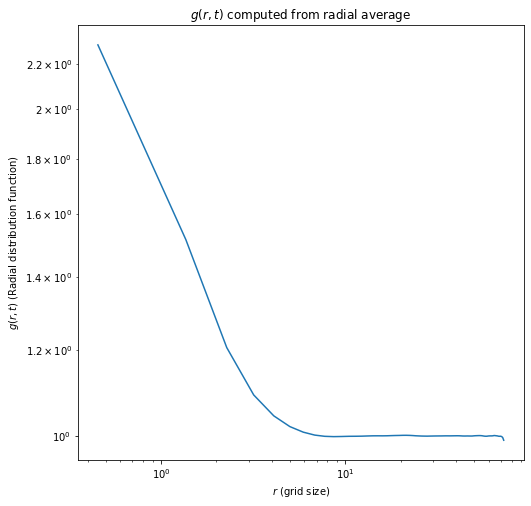

In [202]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs,1+rbin)
ax.set_title(r'$g(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$g(r,t)$ (Radial distribution function)')

## Higher resolution with FFT implementation

By comparing the figures one can see the two produce identical results, a sign of correct implementation. Also the FFT version is also much much much much faster. For example, I can do perform the computation on the full resolution grid in less than half a minute but the naive implementation would probably run for hours or days. 

There is a high resolution version of all the plots

Epsilon: 1.6689299e-08
(256, 256) (256, 256)


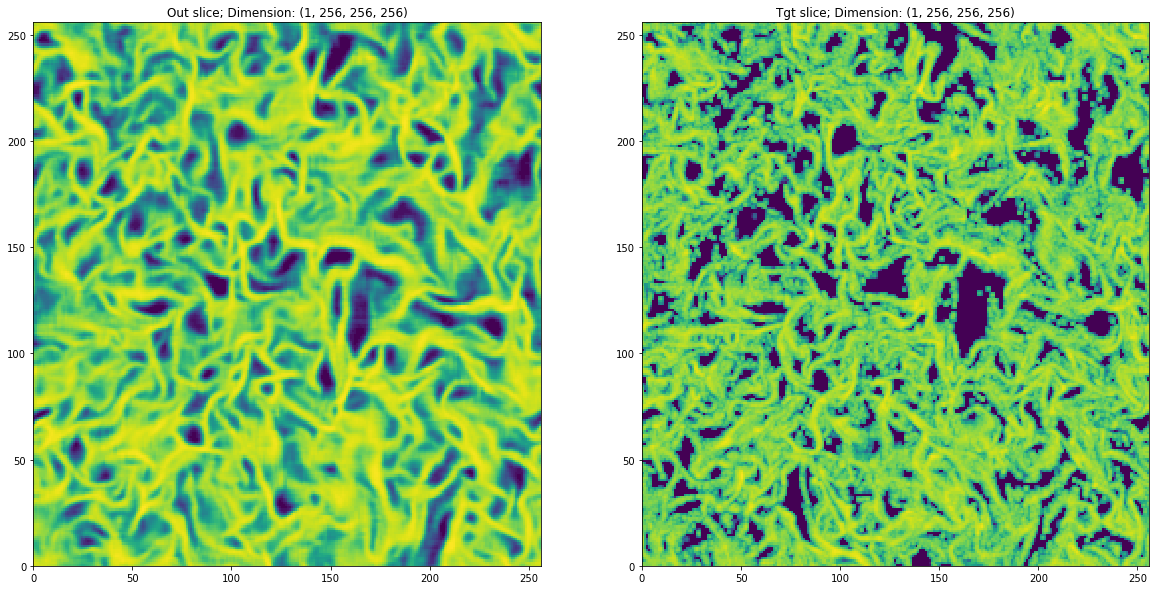

In [219]:
plot_compare(downsample(npys_out[0],(1,1,1)),downsample(npys_tgt[0],(1,1,1))) # Downsample to allow the slow dcf to run faster

In [203]:
dcf_high_res = dcf_fft(downsample(npys_out[0],(1,1,1)).squeeze()) # No down sampling

In [204]:
shifted = np.fft.fftshift(dcf_high_res)
shifted.shape
N_mid = shifted.shape[0]//2
shifted.shape,N_mid

((256, 256, 256), 128)

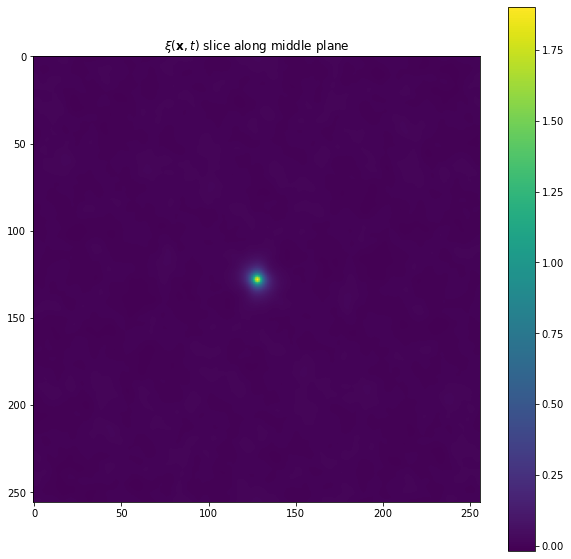

In [205]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
im = ax.imshow(shifted[N_mid,:,:])
plt.title(r'$\xi(\mathbf{x},t)$ slice along middle plane')
plt.colorbar(im, ax=ax)

Text(0.5, 1.0, '$\\xi(\\mathbf{x},t)$ slice along middle line')

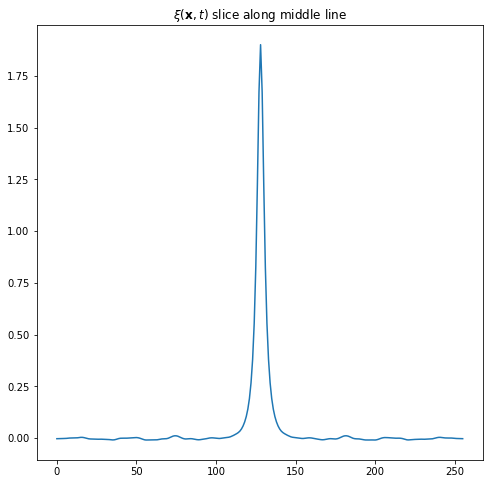

In [206]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
dcf = shifted[N_mid,N_mid,:]
ax.plot(dcf)
ax.set_title(r'$\xi(\mathbf{x},t)$ slice along middle line')

In [207]:
rs,rbin = radial_binning(dcf_high_res,bin_count=300)

Text(0, 0.5, '$\\xi(r,t)$')

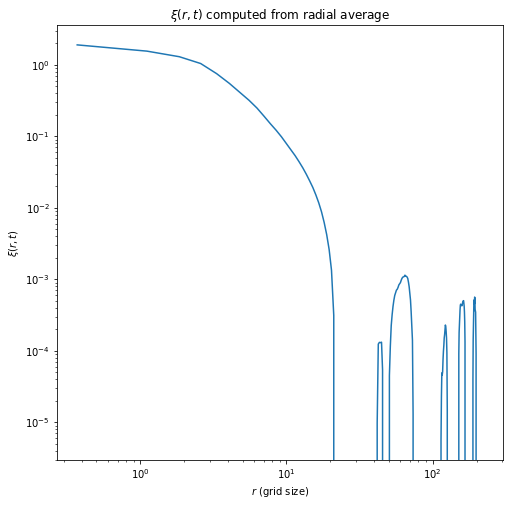

In [208]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs,rbin)
ax.set_title(r'$\xi(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$\xi(r,t)$')

Text(0, 0.5, '$g(r,t)$ (Radial distribution function)')

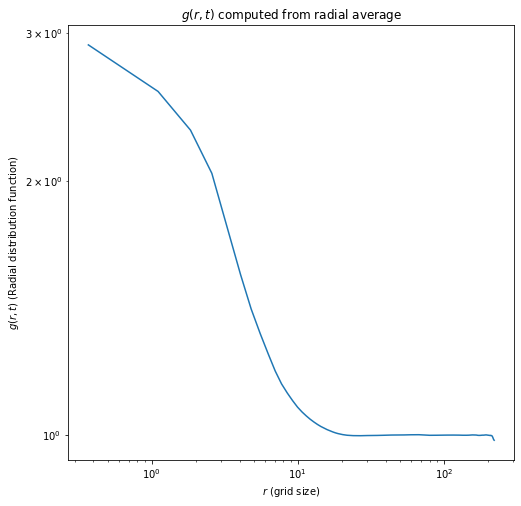

In [209]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs,1+rbin)
ax.set_title(r'$g(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$g(r,t)$ (Radial distribution function)')

These plots can be compared with those by Pan et. al. (2011)


![RDF functions plot by Pan et. al. (2011)](./img/pan-et-al-rdf.png)

## Using the Correlation function and RDF to compare the compare the ML outputs with the target outputs

After demonstrating the correctness of the code, we can now use it to compute and compare statistics for target and output. We begin by plotting a slice (again) of the target vs output

Epsilon: 1.6689299e-08
(256, 256) (256, 256)


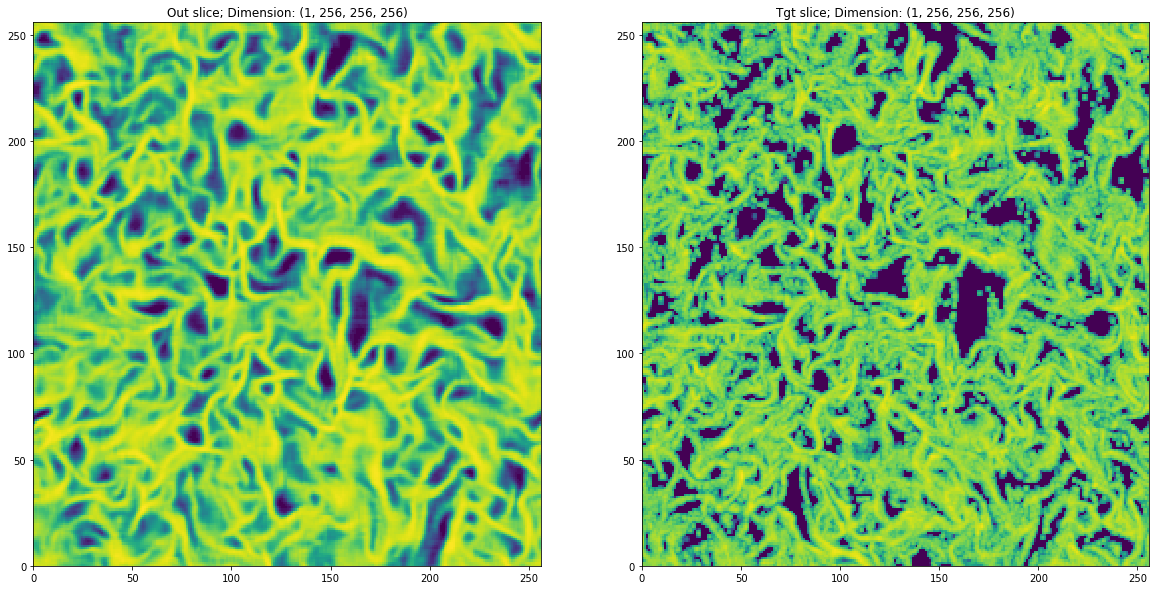

In [220]:
plot_compare(downsample(npys_out[0],(1,1,1)),downsample(npys_tgt[0],(1,1,1))) # Downsample to allow the slow dcf to run faster

Then we can compute the density correlation function for both output and target and radial bin the results

In [221]:
dcf_out = dcf_fft(downsample(npys_out[0],(1,1,1)).squeeze()) # No down sampling
dcf_tgt = dcf_fft(downsample(npys_tgt[0],(1,1,1)).squeeze()) 

In [222]:
rs_out,rbin_out = radial_binning(dcf_out,bin_count=300)
rs_tgt,rbin_tgt = radial_binning(dcf_tgt,bin_count=300)

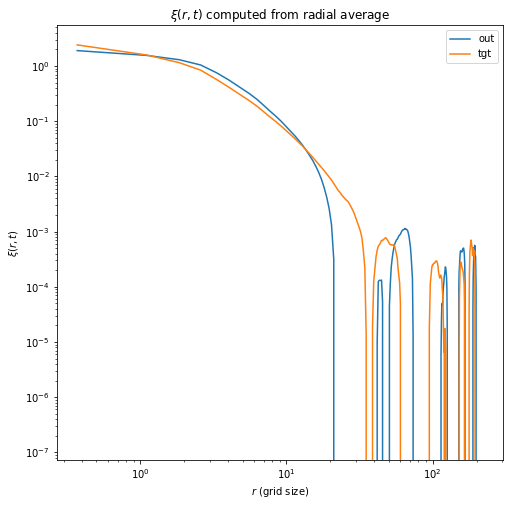

In [224]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs_out,rbin_out,label='out')
ax.loglog(rs_tgt,rbin_tgt,label='tgt')
ax.set_title(r'$\xi(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$\xi(r,t)$')
plt.legend()

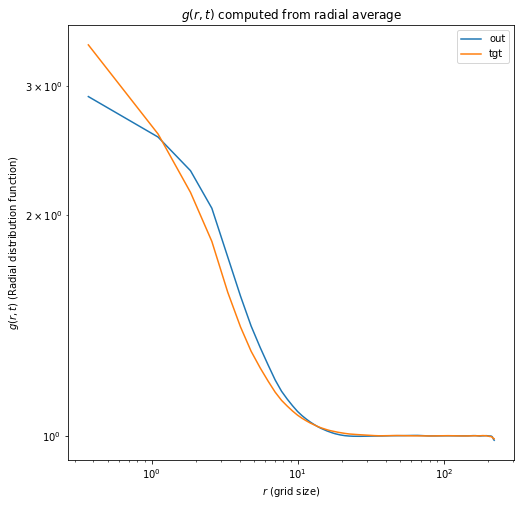

In [227]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax.loglog(rs_out,1+rbin_out,label='out')
ax.loglog(rs_tgt,1+rbin_tgt,label='tgt')
ax.set_title(r'$g(r,t)$ computed from radial average')
ax.set_xlabel(r'$r$ (grid size)')
ax.set_ylabel(r'$g(r,t)$ (Radial distribution function)')
plt.legend()

As shown in the figures, the machine learning algorithm captures the shape of the correlation function quite well. But again, the RDF stats shows that the output field is flatter than the target.